In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import itertools
from itertools import chain
from collections import defaultdict
import math
import re
import os.path
import pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score, f1_score, roc_auc_score
import graphviz 
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn import preprocessing, svm, metrics, tree, decomposition, svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

# personal modules
import ml_pipeline_lch as ml
import ml_explore as exp
import ml_modeling as md
import magiclooping as mp

sns.set(style = "whitegrid", color_codes = True)
%matplotlib inline 

### Read and Pre-Process Data

#### Read Data

In [2]:
outcomes_df = ml.retrieve_data(filename = 'data/outcomes.csv', headers = True, set_ind = 0)

In [3]:
outcomes_df.head()

,is_exciting,at_least_1_teacher_referred_donor,fully_funded,at_least_1_green_donation,great_chat,three_or_more_non_teacher_referred_donors,one_non_teacher_referred_donor_giving_100_plus,donation_from_thoughtful_donor,great_messages_proportion,teacher_referred_count,non_teacher_referred_count
projectid,,,,,,,,,,,
ffffc4f85b60efc5b52347df489d0238,f,NaN,f,NaN,f,NaN,NaN,NaN,NaN,NaN,NaN
ffffac55ee02a49d1abc87ba6fc61135,f,f,t,t,f,t,f,f,57.0,0.0,7.0
ffff97ed93720407d70a2787475932b0,f,f,t,t,t,t,t,f,100.0,0.0,3.0
ffff418bb42fad24347527ad96100f81,f,f,f,t,t,f,f,f,100.0,0.0,1.0
ffff2d9c769c8fb5335e949c615425eb,t,t,t,t,t,f,t,f,63.0,6.0,2.0


In [4]:
projects_df = ml.retrieve_data(filename = 'data/projects.csv', headers = True, set_ind = 0)

In [5]:
project_info = pd.merge(projects_df, pd.DataFrame(outcomes_df['fully_funded']), how = 'inner', right_index = True, left_index = True)

In [6]:
project_info.fully_funded.dtype

dtype('O')

In [7]:
project_info.head()

,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,school_district,...,poverty_level,grade_level,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,date_posted,fully_funded
projectid,,,,,,,,,,,,,,,,,,,,,
62526d85d2a1818432d03d600969e99c,ebc7c90b6c92a069432e0714b8d93dfd,5aca9711ff0e4b37db48701f46f73036,1.713710e+11,41.972419,-88.174597,Bartlett,IL,60103.0,suburban,Elgin School District U-46,...,moderate poverty,Grades 3-5,30.0,444.36,522.78,7.0,f,f,2013-12-31,t
33d59ac771b80222ad63ef0f4ac47ade,de83b4c1f6428a15032c207c1d5e572a,d91a805b213bf74ae77b94e0de2b73ad,1.601530e+11,43.501154,-112.056780,Idaho Falls,ID,83402.0,urban,Idaho Falls School District 91,...,high poverty,Grades 3-5,30.0,233.24,274.40,30.0,f,f,2013-12-31,f
1a3aaeffc56dd2a421e37d8298024c0a,f4c9ed095b85458dcf858e25f203af00,9310d3eb447a4e46bc5fc31ed007ceac,3.302610e+11,42.888244,-71.320224,Derry,NH,3038.0,suburban,School Administrative Unit 10,...,moderate poverty,Grades 6-8,30.0,285.09,335.40,230.0,f,f,2013-12-31,f
33aa19ee4da4c5adf47d0dfb84fab5ef,17768031eb40de8d4497dbb54df48742,9ac70da58322783f82152eecc140a812,5.103240e+11,37.476158,-77.488397,Richmond,VA,23224.0,urban,Richmond City School District,...,highest poverty,Grades PreK-2,30.0,232.94,274.05,18.0,f,f,2013-12-31,f
e31c0ea8b68f404699dfb0d39e9bc99b,0f1bc5b4700fd33383be104442660178,cb9f688cf59e3ee22a087d616ca8f5d7,1.709930e+11,41.952851,-87.650233,Chicago,IL,60613.0,urban,Ravenswood-ridge Elem Network,...,highest poverty,Grades 6-8,30.0,513.41,604.01,70.0,t,f,2013-12-31,t


### Date Transformation and Narrowing

#### Period Transformation

In [8]:
project_info['date_posted'] = ml.convert_dates(project_info['date_posted'])

In [9]:
project_info['year'] = project_info['date_posted'].apply(lambda x: x.year)

In [10]:
project_info['month'] = project_info['date_posted'].apply(lambda x: x.month)

In [11]:
project_info['year'].unique()

array([2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003,
       2002])

In [12]:
project_info = project_info[(project_info['date_posted'] >= datetime.strptime('2011-01-01', '%Y-%m-%d')) & (project_info['date_posted'] <= datetime.strptime('2013-12-31', '%Y-%m-%d'))]            
                                     

In [13]:
project_info['year'].unique()

array([2013, 2012, 2011])

### Data Set Exploration

In [14]:
project_info.describe().round(3).transpose()

,count,mean,std,min,25%,50%,75%,max
school_ncesid,328293.0,2.503127e+11,1.648173e+11,1.000050e+10,6.372301e+10,2.400090e+11,3.904440e+11,6.100008e+11
school_latitude,353151.0,3.686900e+01,4.927000e+00,1.824900e+01,3.391600e+01,3.667600e+01,4.068000e+01,6.725800e+01
school_longitude,353151.0,-9.539800e+01,1.811800e+01,-1.716910e+02,-1.172470e+02,-8.988600e+01,-8.076200e+01,-6.662800e+01
school_zip,353151.0,5.630176e+04,3.104352e+04,4.100000e+02,2.938800e+04,6.061300e+04,9.000700e+04,9.992600e+04
fulfillment_labor_materials,353151.0,3.222000e+01,2.484000e+00,3.000000e+01,3.000000e+01,3.000000e+01,3.500000e+01,3.500000e+01
total_price_excluding_optional_support,353151.0,5.313720e+02,8.440690e+02,3.703000e+01,2.887500e+02,4.272700e+02,6.067200e+02,1.397254e+05
total_price_including_optional_support,353151.0,6.251440e+02,9.930230e+02,4.356000e+01,3.397100e+02,5.026700e+02,7.137900e+02,1.643828e+05
students_reached,353050.0,9.418700e+01,1.569870e+02,1.000000e+00,2.300000e+01,3.100000e+01,1.000000e+02,1.214300e+04
year,353151.0,2.012077e+03,8.130000e-01,2.011000e+03,2.011000e+03,2.012000e+03,2.013000e+03,2.013000e+03
month,353151.0,6.933000e+00,3.591000e+00,1.000000e+00,3.000000e+00,8.000000e+00,1.000000e+01,1.200000e+01


In [15]:
summary_df, types = ml.summarize_df(project_info)

In [16]:
summary_df.sort_values(by='col_type')

,num_values,num_nulls,unique_values,data_type,col_type,most_common,prevalence
col_name,,,,,,,
teacher_acctid,353151,0,157144,object,ID,214acf23d183dfa2f1dc16e7b3658320,0.049271
schoolid,353151,0,44833,object,ID,9943fdb43ab5f2b53f27e961caf9e90a,0.134787
school_ncesid,328293,24858,41107,float64,ID,3.60015e+11,0.144992
fully_funded,353151,0,2,object,binary,t,70.139402
eligible_almost_home_match,353151,0,2,object,binary,f,95.572149
eligible_double_your_impact_match,353151,0,2,object,binary,f,68.297414
teacher_ny_teaching_fellow,353151,0,2,object,binary,f,98.978907
school_charter_ready_promise,353151,0,2,object,binary,f,99.388364
school_kipp,353151,0,2,object,binary,f,99.336261


In [17]:
# take a closer look at most prevalent values in multi-value columns
summary_df[summary_df['col_type'] != 'binary'].sort_values(by='prevalence', ascending = False).head(10)

,num_values,num_nulls,unique_values,data_type,col_type,most_common,prevalence
col_name,,,,,,,
school_metro,310130,43021,4,object,multi,urban,57.506207
fulfillment_labor_materials,353151,0,2,float64,numeric,30,55.593783
poverty_level,353151,0,4,object,multi,highest poverty,54.797523
teacher_prefix,353151,0,4,object,multi,Mrs.,48.422629
primary_focus_area,353116,35,8,object,tops,Literacy & Language,45.870762
grade_level,353145,6,5,object,multi,Grades PreK-2,38.227357
year,353151,0,3,int64,numeric,2013,37.187775
secondary_focus_area,237065,116086,8,object,tops,Literacy & Language,36.059309
resource_type,353109,42,7,object,tops,Technology,35.253987


#### Project Types
At a first glance, the 2011-2013 data appears to skewed towards technology to support literacy and writing/ language in low-income, non-magnet schools in urban areas, most of which are fully funded (about 70% of all projects were funded in this period). Just under ten percent of projects are tied to charter and/ or magnet schools.

#### Timing
There are about 4% more projects (about 14K) in 2013 than expected if projects were evenly distributed through the period of interest. As could be expected, the largest proportion of projects occur in September, when the majority of US primary and secondary schools begin their academic years.

In [18]:
types

defaultdict(list,
            {'ID': ['teacher_acctid', 'schoolid', 'school_ncesid'],
             'geo': ['school_latitude',
              'school_longitude',
              'school_city',
              'school_state',
              'school_zip',
              'school_county'],
             'multi': ['school_metro',
              'teacher_prefix',
              'poverty_level',
              'grade_level'],
             'tops': ['school_district',
              'primary_focus_subject',
              'primary_focus_area',
              'secondary_focus_subject',
              'secondary_focus_area',
              'resource_type'],
             'binary': ['school_charter',
              'school_magnet',
              'school_year_round',
              'school_nlns',
              'school_kipp',
              'school_charter_ready_promise',
              'teacher_teach_for_america',
              'teacher_ny_teaching_fellow',
              'eligible_double_your_impact_match',
            

In [19]:
types = ml.recateogrize_col('school_county', 'tops', types)

In [20]:
types = ml.recateogrize_col('school_state', 'tops', types)

In [21]:
types = ml.recateogrize_col('school_city', 'tops', types)

In [22]:
types

defaultdict(list,
            {'ID': ['teacher_acctid', 'schoolid', 'school_ncesid'],
             'geo': ['school_latitude', 'school_longitude', 'school_zip'],
             'multi': ['school_metro',
              'teacher_prefix',
              'poverty_level',
              'grade_level'],
             'tops': ['school_district',
              'primary_focus_subject',
              'primary_focus_area',
              'secondary_focus_subject',
              'secondary_focus_area',
              'resource_type',
              'school_county',
              'school_state',
              'school_city'],
             'binary': ['school_charter',
              'school_magnet',
              'school_year_round',
              'school_nlns',
              'school_kipp',
              'school_charter_ready_promise',
              'teacher_teach_for_america',
              'teacher_ny_teaching_fellow',
              'eligible_double_your_impact_match',
              'eligible_almost_home_matc

The vast majority of projects are submitted by teachers identifying with traditionally female pronouns. Projects for lassrooms in high-poverty urban areas are nearly 90% of the dataset, and over 60% of projects are for students who have not yet reached 6th grade.

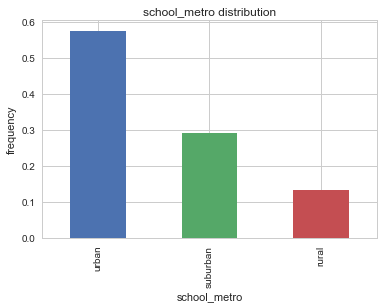

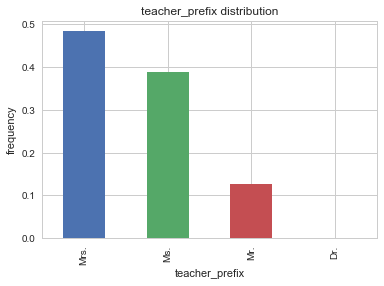

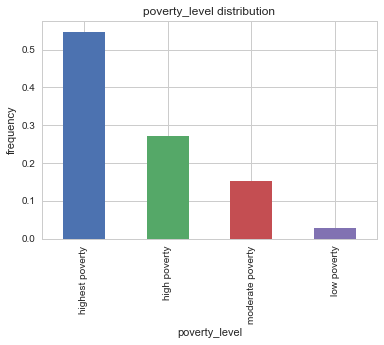

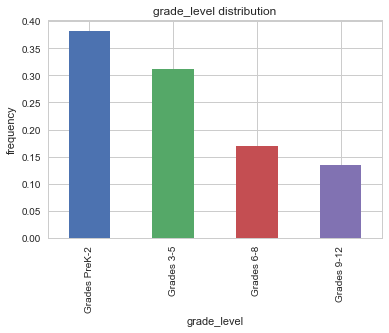

In [23]:
exp.plot_value_counts(project_info, types, 'multi', norm = True)

"Specialized" programs and teachers (i.e., charter schools, magnet programs, Teach for America and NY Teaching fellow classrooms, KIPP schools, NLNS schools) make up an extremely small portion of the data set (less than 16%). This supports the idea that    these programs may have alternate funding sources to meet their needs than higher-poverty schools and classrooms outside of such programs, but could very well just be an indicator that donation platform has not focused sufficient marketing efforts on these populations.

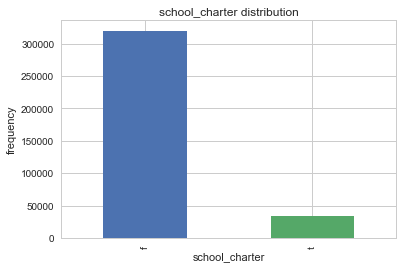

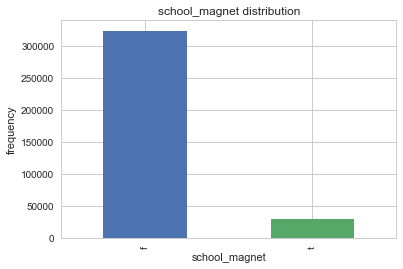

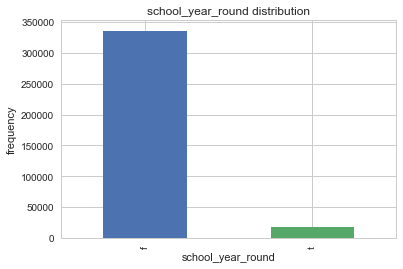

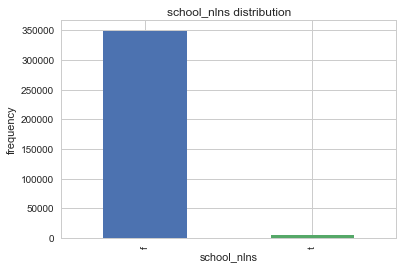

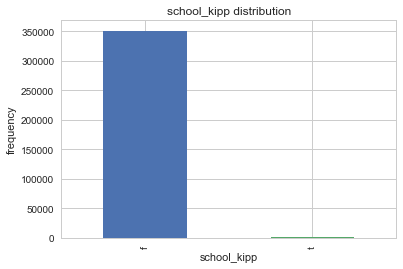

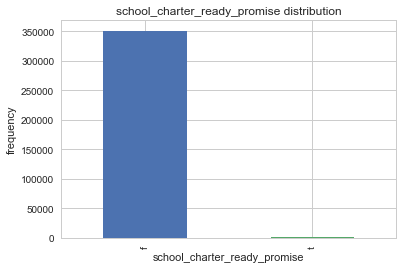

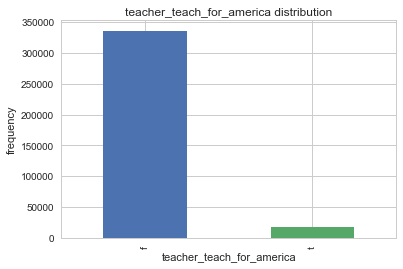

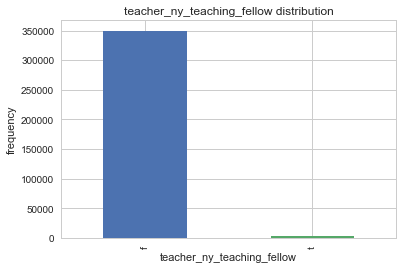

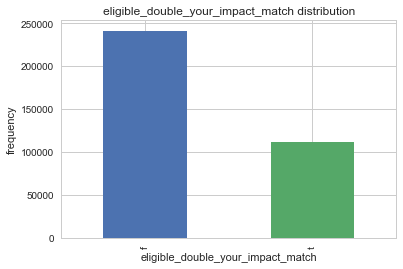

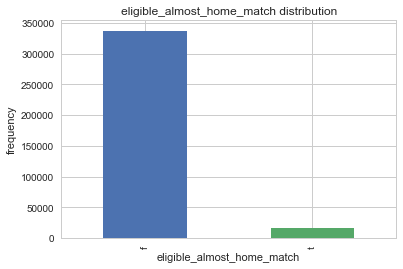

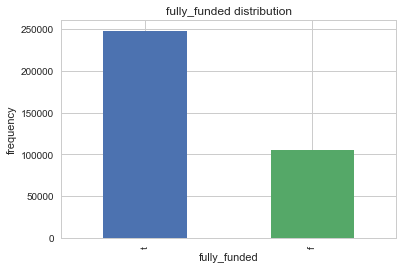

In [24]:
exp.plot_value_counts(project_info, types, 'binary')

There is noticeable correlation between the number of projects that are fully funded and those eligible for the platform's "Double Your Match" status, which could be an indicator that the doubling program is successfully gives projects the "final push" they need to reach full funding.

Exploration of the two features together supports this theory with 77% of fully funded projects being eligible for the Double Your Impact program, though further investigation outside the scope of this analysis is required to make any assertions causality.

In [135]:
doubling = project_info.groupby(['fully_funded', 'eligible_double_your_impact_match'])['eligible_almost_home_match'].count().unstack('eligible_double_your_impact_match')
doubling/ doubling.sum()


eligible_double_your_impact_match,f,t
fully_funded,,
f,0.334545,0.221181
t,0.665455,0.778819


Each progressive year seems to feature an earlier, but less drastic, decrease in projects for the summer months than the year prior. As noted above, more projects are submited over the year, but over time, projects become more concentrated at the beginning of the school year, as illustrated in the table and graph below.

In [131]:
cm = sns.light_palette("orange", as_cmap=True)
by_month = project_info.groupby(['month', 'year'])['fully_funded'].count().unstack('year')
pd.DataFrame(by_month/ by_month.sum()).style.background_gradient(cmap=cm)

year,2011,2012,2013
month,,,
1,0.101347,0.129062,0.0621264
2,0.0823064,0.104178,0.0651798
3,0.0948117,0.0783755,0.055144
4,0.0912895,0.0456872,0.0466691
5,0.0444931,0.0466138,0.0504611
6,0.0440612,0.0397361,0.0493265
7,0.0589178,0.0563906,0.0627356
8,0.103161,0.0827198,0.115146
9,0.100023,0.129147,0.153622


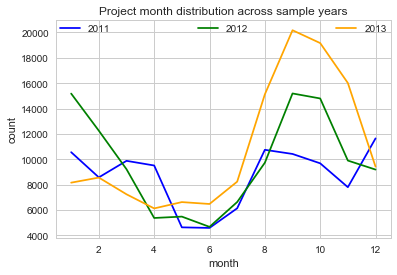

In [25]:
proj_2011 = project_info[project_info['year']==2011][['fully_funded', 'month']].groupby('month').count()
proj_2012 = project_info[project_info['year']==2012][['fully_funded', 'month']].groupby('month').count()
proj_2013 = project_info[project_info['year']==2013][['fully_funded', 'month']].groupby('month').count()

plt.plot(proj_2011, c = 'blue', label = '2011') 
plt.plot(proj_2012, c = 'green', label = '2012') 
plt.plot(proj_2013, c = 'orange', label = '2013')
plt.xlabel('month')
plt.title('Project month distribution across sample years')
plt.ylabel('count')
plt.legend(loc=1,ncol=3, mode="expand", borderaxespad=0.)
plt.show()

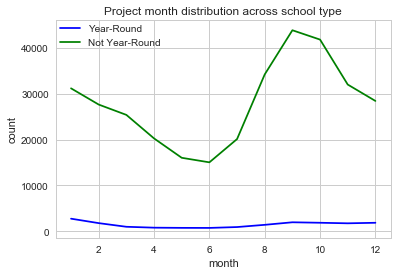

In [122]:
t = project_info[project_info['school_year_round']=='t'][['fully_funded', 'month']].groupby('month').count()
f = project_info[project_info['school_year_round']=='f'][['fully_funded', 'month']].groupby('month').count()

plt.plot(t, c = 'blue', label = 'Year-Round') 
plt.plot(f, c = 'green', label = 'Not Year-Round') 

plt.xlabel('month')
plt.title('Project month distribution across school type')
plt.ylabel('count')
plt.legend(loc='best',ncol=1, mode="expand", borderaxespad=0.)
plt.show()

Surprisingly, there appears to be a slight tapering off of project submissions in summer months for year-round schools as well as schools with summer breaks, though not nearly as pronounced.

In [ ]:
t = project_info[project_info['school_year_round']=='t'][['fully_funded', 'month']].groupby('month').count()
f = project_info[project_info['school_year_round']=='f'][['fully_funded', 'month']].groupby('month').count()

plt.plot(t, c = 'blue', label = 'True') 
plt.plot(f, c = 'green', label = 'False') 

plt.xlabel('month')
plt.title('Project month distribution across school type')
plt.ylabel('count')
plt.legend(loc='best',ncol=1, mode="expand", borderaxespad=0.)
plt.show()

### Outlier Evaluation

In [27]:
maxes = ml.view_max_mins(project_info, max = True)
maxes.tail().round(2)

,school_ncesid,school_latitude,school_longitude,school_zip,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,year,month
0.996,5.509600e+11,48.05,-70.29,98952.0,35.0,3930.71,4624.36,999.0,2013.0,12.0
0.997,5.512330e+11,48.87,-70.23,99343.0,35.0,4810.63,5659.56,999.0,2013.0,12.0
0.998,5.514750e+11,61.19,-69.97,99507.0,35.0,6136.87,7219.85,999.0,2013.0,12.0
0.999,5.516830e+11,61.22,-69.11,99577.0,35.0,8699.96,10235.25,999.0,2013.0,12.0
1.000,6.100008e+11,67.26,-66.63,99926.0,35.0,139725.41,164382.84,12143.0,2013.0,12.0


In [28]:
likely_outliers_upper = ml.view_likely_outliers(project_info)
likely_outliers_upper.tail()

,school_ncesid,school_latitude,school_longitude,school_zip,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,year,month
0.996,2.666241e-09,0.005071,-0.006003,0.002716,0.0,0.185147,0.185147,0.000000,0.0,0.0
0.997,4.954968e-04,0.016860,-0.000961,0.003951,0.0,0.223858,0.223859,0.000000,0.0,0.0
0.998,4.390019e-04,0.252270,-0.003614,0.001651,0.0,0.275690,0.275690,0.000000,0.0,0.0
0.999,3.771853e-04,0.000442,-0.012383,0.000703,0.0,0.417654,0.417654,0.000000,0.0,0.0
1.000,1.057089e-01,0.098641,-0.035873,0.003505,0.0,15.060468,15.060462,11.155155,0.0,0.0


In [29]:
mins = ml.view_max_mins(project_info, max = False)
mins

,school_ncesid,school_latitude,school_longitude,school_zip,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,year,month
0.000,1.000050e+10,18.249140,-171.690554,410.0,30.0,37.0300,43.5600,1.0,2011.0,1.0
0.001,1.002700e+10,20.864705,-158.192448,1118.0,30.0,132.8400,156.2800,2.0,2011.0,1.0
0.002,1.010200e+10,21.344914,-158.012455,1602.0,30.0,134.3330,158.0430,3.0,2011.0,1.0
0.003,1.017400e+10,21.384429,-157.871713,1610.0,30.0,135.9900,159.9900,4.0,2011.0,1.0
0.004,1.020400e+10,21.512068,-157.728836,1840.0,30.0,137.1900,161.4000,5.0,2011.0,1.0
0.005,1.023700e+10,25.397676,-155.096330,1852.0,30.0,138.4200,162.8500,5.0,2011.0,1.0
0.006,1.026500e+10,25.599142,-149.808700,2026.0,30.0,139.3900,163.9900,6.0,2011.0,1.0
0.007,1.029113e+10,25.699131,-149.720276,2119.0,30.0,140.1205,164.8505,6.0,2011.0,1.0
0.008,1.033900e+10,25.743486,-124.206627,2122.0,30.0,140.8900,165.7500,6.0,2011.0,1.0
0.009,2.001800e+10,25.777018,-123.725756,2127.0,30.0,141.5500,166.5300,6.0,2011.0,1.0


In [30]:
likely_outliers_lower = ml.view_likely_outliers(project_info, max = False)
likely_outliers_lower

,school_ncesid,school_latitude,school_longitude,school_zip,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,year,month
0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.001,2.649951e-03,0.143325,-0.078619,1.726829,0.0,2.587362,2.587695,1.000000,0.0,0.0
0.002,7.479675e-03,0.023015,-0.001138,0.432916,0.0,0.011239,0.011281,0.500000,0.0,0.0
0.003,7.127319e-03,0.001851,-0.000891,0.004994,0.0,0.012335,0.012319,0.333333,0.0,0.0
0.004,2.948710e-03,0.005969,-0.000905,0.142857,0.0,0.008824,0.008813,0.250000,0.0,0.0
0.005,3.234090e-03,0.180625,-0.016690,0.006522,0.0,0.008966,0.008984,0.000000,0.0,0.0
0.006,2.735179e-03,0.007932,-0.034093,0.093952,0.0,0.007008,0.007000,0.200000,0.0,0.0
0.007,2.545706e-03,0.003906,-0.000590,0.045903,0.0,0.005241,0.005247,0.000000,0.0,0.0
0.008,4.651396e-03,0.001726,-0.170409,0.001416,0.0,0.005492,0.005456,0.000000,0.0,0.0
0.009,9.361638e-01,0.001303,-0.003872,0.002356,0.0,0.004685,0.004706,0.000000,0.0,0.0


#### Create copy of dataframe to manipulate and explore

In [31]:
# copy dataframe
manip_df = project_info[list(project_info.columns)]

In [32]:
# view copy
manip_df.head()

,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,school_district,...,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,date_posted,fully_funded,year,month
projectid,,,,,,,,,,,,,,,,,,,,,
62526d85d2a1818432d03d600969e99c,ebc7c90b6c92a069432e0714b8d93dfd,5aca9711ff0e4b37db48701f46f73036,1.713710e+11,41.972419,-88.174597,Bartlett,IL,60103.0,suburban,Elgin School District U-46,...,30.0,444.36,522.78,7.0,f,f,2013-12-31,t,2013,12
33d59ac771b80222ad63ef0f4ac47ade,de83b4c1f6428a15032c207c1d5e572a,d91a805b213bf74ae77b94e0de2b73ad,1.601530e+11,43.501154,-112.056780,Idaho Falls,ID,83402.0,urban,Idaho Falls School District 91,...,30.0,233.24,274.40,30.0,f,f,2013-12-31,f,2013,12
1a3aaeffc56dd2a421e37d8298024c0a,f4c9ed095b85458dcf858e25f203af00,9310d3eb447a4e46bc5fc31ed007ceac,3.302610e+11,42.888244,-71.320224,Derry,NH,3038.0,suburban,School Administrative Unit 10,...,30.0,285.09,335.40,230.0,f,f,2013-12-31,f,2013,12
33aa19ee4da4c5adf47d0dfb84fab5ef,17768031eb40de8d4497dbb54df48742,9ac70da58322783f82152eecc140a812,5.103240e+11,37.476158,-77.488397,Richmond,VA,23224.0,urban,Richmond City School District,...,30.0,232.94,274.05,18.0,f,f,2013-12-31,f,2013,12
e31c0ea8b68f404699dfb0d39e9bc99b,0f1bc5b4700fd33383be104442660178,cb9f688cf59e3ee22a087d616ca8f5d7,1.709930e+11,41.952851,-87.650233,Chicago,IL,60613.0,urban,Ravenswood-ridge Elem Network,...,30.0,513.41,604.01,70.0,t,f,2013-12-31,t,2013,12


#### Drop Unwanted Columns

In [33]:
types['geo']

['school_latitude', 'school_longitude', 'school_zip']

In [34]:
types['ID']

['teacher_acctid', 'schoolid', 'school_ncesid']

In [35]:
all_drops = types['ID'] + types['geo']

In [36]:
ml.drop_unwanted(manip_df, all_drops)

#### Outlier Removal

In [37]:
# total price and students reached values should not be inf 
ml.remove_over_under_threshold(manip_df, col = 'total_price_excluding_optional_support', min_val = 0, max_val = False, lwr_threshold = 0.001, upr_threshold = False)
ml.remove_over_under_threshold(manip_df, col = 'total_price_including_optional_support', min_val = 0, max_val = False, lwr_threshold = 0.001, upr_threshold = False)
ml.remove_over_under_threshold(manip_df, col = 'students_reached', min_val = 0, max_val = False, lwr_threshold = 0.005, upr_threshold = False)


In [38]:
# check that expected values were removed
likely_outliers_lower_post = ml.view_likely_outliers(manip_df, max = False)
likely_outliers_lower_post

,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,year,month
0.000,NaN,NaN,NaN,NaN,NaN,NaN
0.001,0.0,0.011051,0.011057,0.000000,0.0,0.0
0.002,0.0,0.012375,0.012354,0.000000,0.0,0.0
0.003,0.0,0.008899,0.008940,0.200000,0.0,0.0
0.004,0.0,0.008966,0.008984,0.000000,0.0,0.0
0.005,0.0,0.007008,0.007001,0.000000,0.0,0.0
0.006,0.0,0.005237,0.005245,0.000000,0.0,0.0
0.007,0.0,0.005567,0.005521,0.166667,0.0,0.0
0.008,0.0,0.004614,0.004646,0.000000,0.0,0.0
0.009,0.0,0.004027,0.004024,0.000000,0.0,0.0


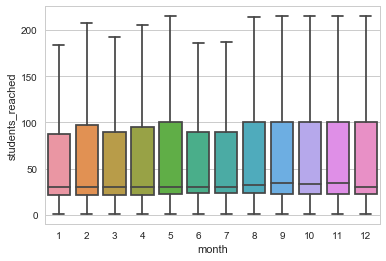

In [39]:
#  ax = sns.boxplot(data = project_info, x="students_reached", col = 'grade_level')
ax = sns.boxplot(x="month", y="students_reached", data=project_info, showfliers=False)

As could be expected, more students are reached during the typical US school year (August/ September to May/ June), with slight dips in January and March correlating with common holiday periods (i.e., winter break, spring break), and a similar decrease in the summer months of June and July.

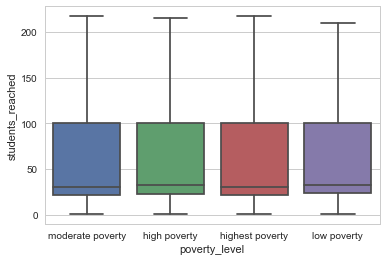

In [120]:
ax = sns.boxplot(x="poverty_level", y="students_reached", data=project_info, showfliers=False)

The bulk of students reached are fairly uniformly distributed across poverty levels, however, several outliers in excess of 4000 students (not pictured) raise the average poverty level of students reached by projects in the dataset.

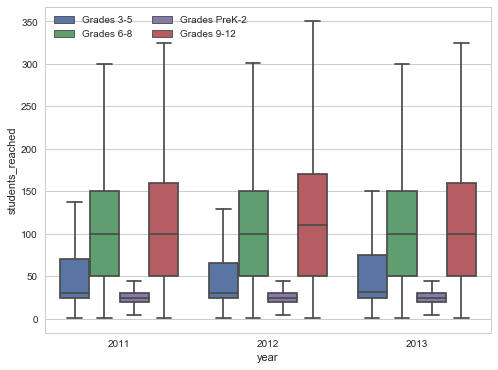

In [110]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
match_pal = {"Grades 3-5": "b", "Grades 6-8": "g", "Grades PreK-2":"m", "Grades 9-12":"r"}
ax = sns.boxplot(x="year", y="students_reached", data=project_info, hue="grade_level" ,showfliers=False, palette=match_pal)

plt.legend(loc=2, ncol = 2)

Though Grades PreK-2 is the most common project age group in the data set, they appear to reach far fewer students on average than in older grades, excluding outliers. This could be due to smaller class sizes for these more high-energy age groups, in the case that a  teacher's project is submitted to benefit only his or her class. The larger reach of older age groups, such as middle and high school, could be an indicator that these projects are more commonly submitted for resources for an entire school or grade.

In [118]:
resources = manip_df.groupby(['resource_type', 'grade_level'])['school_district'].count().unstack('grade_level').fillna(0)
resources/ resources.sum()

grade_level,Grades 3-5,Grades 6-8,Grades 9-12,Grades PreK-2
resource_type,,,,
Books,0.209123,0.223973,0.205368,0.184883
Other,0.111996,0.076523,0.065506,0.143759
Supplies,0.308830,0.323300,0.324722,0.346372
Technology,0.365400,0.366376,0.392158,0.322161
Trips,0.003606,0.008912,0.011009,0.002069
Visitors,0.001045,0.000916,0.001237,0.000756


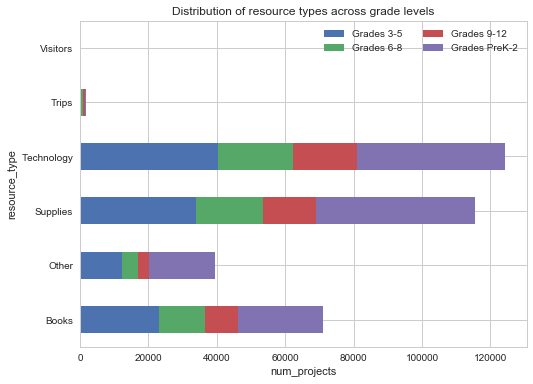

In [107]:
fig, ax = plt.subplots()
resources.plot(kind='barh', stacked=True, ax=ax)
fig.set_size_inches(8, 6)

ax.set_title("Distribution of resource types across grade levels")
plt.xlabel('num_projects')
plt.legend(loc=1, ncol=2, mode="tight", borderaxespad=0.5)

After exploring the breakdown of project types across grade levels, it appears that all grade levels request at roughly the same rate for each category, with older grades requesting technology slightly more often.

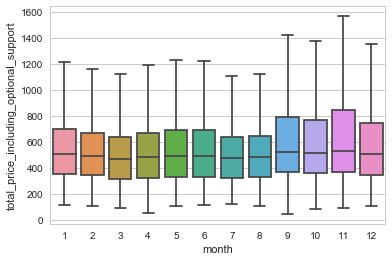

In [42]:
ax = sns.boxplot(y="total_price_including_optional_support", x="month", data=project_info, showfliers=False)

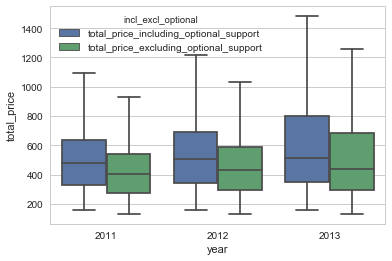

In [55]:
melt_test = pd.melt(manip_df[['total_price_including_optional_support', 'total_price_excluding_optional_support', 'year']], id_vars=['year'], value_vars=['total_price_including_optional_support', 'total_price_excluding_optional_support'], var_name='incl_excl_optional', value_name='total_price')
melt_test
sns.boxplot(y="total_price", x="year", data=melt_test, hue="incl_excl_optional", showfliers=False)

The total amounts requested per project in the dataset appear to grow over time not only for the bulk of projects (outliers not pictured), but also the range of requested amounts.

### Feature Generation

#### Binary Conversion

Binary variables are converted to integers.

In [38]:
types['binary']

['school_charter',
 'school_magnet',
 'school_year_round',
 'school_nlns',
 'school_kipp',
 'school_charter_ready_promise',
 'teacher_teach_for_america',
 'teacher_ny_teaching_fellow',
 'eligible_double_your_impact_match',
 'eligible_almost_home_match',
 'fully_funded']

In [39]:
# convert binary values to integers
ml.make_boolean(manip_df, types['binary'], value_1s = 't')

In [40]:
# confirm change
manip_df.school_charter.unique()

array([0, 1])

In [41]:
# view number and names of columns in dataframe
print(manip_df.columns)
print(len(manip_df.columns))

Index(['school_city', 'school_state', 'school_metro', 'school_district',
       'school_county', 'school_charter', 'school_magnet', 'school_year_round',
       'school_nlns', 'school_kipp', 'school_charter_ready_promise',
       'teacher_prefix', 'teacher_teach_for_america',
       'teacher_ny_teaching_fellow', 'primary_focus_subject',
       'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area',
       'resource_type', 'poverty_level', 'grade_level',
       'fulfillment_labor_materials', 'total_price_excluding_optional_support',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'eligible_almost_home_match',
       'date_posted', 'fully_funded', 'year', 'month'],
      dtype='object')
31


### Split Train and Test Sets

Temporally split data frames are created from the base dataframe for a range of training periods (test period length remaining constant) from 12 months to 33 months in increments of three months, returning 8 train-test-sets.

In [46]:
(all_sets, date_ref) = ml.create_expanding_splits(manip_df, 
                                                  total_periods = 36, 
                                                  dates = 'date_posted', 
                                                  train_period_base = 12, 
                                                  test_period_size = 3, 
                                                  period = 'month', 
                                                  defined_start = '2011-01-01')


original train period lenth: 12
train: (104547, 31), test: (36917, 31)
original train period lenth: 15
train: (141318, 31), test: (15640, 31)
original train period lenth: 18
train: (156824, 31), test: (31978, 31)
original train period lenth: 21
train: (188309, 31), test: (33947, 31)
original train period lenth: 24
train: (222062, 31), test: (24079, 31)
original train period lenth: 27
train: (245843, 31), test: (19454, 31)
original train period lenth: 30
train: (265235, 31), test: (44368, 31)
original train period lenth: 33
train: (309067, 31), test: (44084, 31)


In [47]:
date_ref

,training_start,training_period_end,test_period_start,test_period_end
0,2011-01-01,2012-01-01,2012-01-02,2012-04-02
1,2011-01-01,2012-04-01,2012-04-02,2012-07-02
2,2011-01-01,2012-07-01,2012-07-02,2012-10-02
3,2011-01-01,2012-10-01,2012-10-02,2013-01-02
4,2011-01-01,2013-01-01,2013-01-02,2013-04-02
5,2011-01-01,2013-04-01,2013-04-02,2013-07-02
6,2011-01-01,2013-07-01,2013-07-02,2013-10-02
7,2011-01-01,2013-10-01,2013-10-02,2013-12-31


### Create training-set-specific dummy variables

#### Pre-processing and Dummy Variable Creationn
A binary dummy column replaces each unique value in non-binary and non-numeric features, including NaNs, for compatibility with sklearn model functions. 

For numeric columns, missing values are imputed based on column averages for each training set, and applied to its corresponding test set.

In [48]:
fg_sets = [ml.iza_process(train, test, types, tops_threshold = 0.5, binary = None) for (train, test) in all_sets]



Converted nonbinary, non-numeric columns to dummies.
Filled missing values and normalizied values in numeric columns.
Moving to next set!
Converted nonbinary, non-numeric columns to dummies.
Filled missing values and normalizied values in numeric columns.
Moving to next set!
Converted nonbinary, non-numeric columns to dummies.
Filled missing values and normalizied values in numeric columns.
Moving to next set!
Converted nonbinary, non-numeric columns to dummies.
Filled missing values and normalizied values in numeric columns.
Moving to next set!
Converted nonbinary, non-numeric columns to dummies.
Filled missing values and normalizied values in numeric columns.
Moving to next set!
Converted nonbinary, non-numeric columns to dummies.
Filled missing values and normalizied values in numeric columns.
Moving to next set!
Converted nonbinary, non-numeric columns to dummies.
Filled missing values and normalizied values in numeric columns.
Moving to next set!
Converted nonbinary, non-numeric c

In [49]:
# ensure symmetric creation of features across train-test sets
for train, test in fg_sets:
    print(train.shape)
    print(test.shape)
    print()

(104547, 104)
(36917, 104)

(141318, 104)
(15640, 104)

(156824, 104)
(31978, 104)

(188309, 104)
(33947, 104)

(222062, 104)
(24079, 104)

(245843, 104)
(19454, 104)

(265235, 104)
(44368, 104)

(309067, 104)
(44084, 104)



In [50]:
# double-check coulumn data types
ml.check_col_types(fg_sets[0][1])

,data_type
school_charter,int64
school_magnet,int64
school_year_round,int64
school_nlns,int64
school_kipp,int64
school_charter_ready_promise,int64
teacher_teach_for_america,int64
teacher_ny_teaching_fellow,int64
fulfillment_labor_materials,float64
total_price_excluding_optional_support,float64


In [57]:
def temporal_train_test_split(df, outcome_var, exclude = [], subset_cols = False):
    if not subset_cols:
        skips = [outcome_var] + exclude
        Xs = df.drop(skips, axis = 1)
    else:
        Xs = df[subset_cols]
    
    Ys = df[outcome_var]

    return Xs, Ys

In [58]:
def run_models(train_test_tuples, outcome_var):
    all_results = []
    for i, (train, test) in enumerate(train_test_tuples):
        print("set", i)

        x_train, y_train = temporal_train_test_split(train, outcome_var)
        x_test, y_test = temporal_train_test_split(test, outcome_var)
        results = md.cf_loop(x_train, y_train, x_test, y_test, 
                             ks = [1, 2, 5, 10, 20, 30, 50], 
                             set_num = i, params_dict = None, 
                             which_clfs = ("LogisticRegression", "KNN", "AdaBoost", 
                                           "NaiveBayes", "Decision Tree", "Bagging"))
        all_results.append(results)

    return pd.concat(all_results, ignore_index = True)


In [60]:
tessss = md.run_models(fg_sets, outcome_var = 'fully_funded')

set 0
Creating classifier: LogisticRegression
Creating args for: LogisticRegression models
Creating classifier: KNN
Creating args for: KNN models
Creating classifier: AdaBoost
Creating args for: AdaBoost models
Creating classifier: NaiveBayes
Creating args for: NaiveBayes models
Creating classifier: Decision Tree
Creating classifier: Bagging
Creating args for: Bagging models
set 1
Creating classifier: LogisticRegression
Creating args for: LogisticRegression models
Creating classifier: KNN
Creating args for: KNN models
Creating classifier: AdaBoost
Creating args for: AdaBoost models
Creating classifier: NaiveBayes
Creating args for: NaiveBayes models
Creating classifier: Decision Tree
Creating classifier: Bagging
Creating args for: Bagging models
set 2
Creating classifier: LogisticRegression
Creating args for: LogisticRegression models
Creating classifier: KNN
Creating args for: KNN models
Creating classifier: AdaBoost
Creating args for: AdaBoost models
Creating classifier: NaiveBayes
C

In [61]:
tessss.sort_values(by='auc-roc', ascending = False)

,set_num,model_type,clf,parameters,baseline_precision,baseline_recall,auc-roc,precision_at_1,recall_at_1,f1_at_1,...,f1_at_10,precision_at_20,recall_at_20,f1_at_20,precision_at_30,recall_at_30,f1_at_30,precision_at_50,recall_at_50,f1_at_50
19,3,Bagging,"(LogisticRegression(C=100000.0, class_weight=N...",{},0.739918,1.0,0.676032,0.964602,0.013019,0.025690,...,0.222292,0.906024,0.244884,0.385558,0.888747,0.360339,0.512775,0.840511,0.567959,0.677865
29,5,Bagging,"(LogisticRegression(C=100000.0, class_weight=N...",{},0.661766,1.0,0.648234,0.876289,0.013205,0.026018,...,0.217963,0.805141,0.243281,0.373658,0.789925,0.358086,0.492785,0.759021,0.573481,0.653334
34,6,Bagging,"(LogisticRegression(C=100000.0, class_weight=N...",{},0.736251,1.0,0.647980,0.945824,0.012827,0.025310,...,0.217185,0.875690,0.237862,0.374106,0.854245,0.348068,0.494606,0.823927,0.559542,0.666472
15,3,LogisticRegression,"LogisticRegression(C=0.01, class_weight=None, ...","{'penalty': 'l1', 'C': 0.01}",0.739918,1.0,0.643461,0.920354,0.012421,0.024512,...,0.214576,0.877743,0.237240,0.373523,0.854379,0.346405,0.492947,0.821599,0.555180,0.662612
18,3,NaiveBayes,GaussianNB(priors=None),{},0.739918,1.0,0.633057,0.867257,0.011705,0.023098,...,0.201249,0.835764,0.225894,0.355659,0.837588,0.339597,0.483259,0.821069,0.554821,0.662184
28,5,NaiveBayes,GaussianNB(priors=None),{},0.661766,1.0,0.625491,0.783505,0.011807,0.023263,...,0.208111,0.768380,0.232173,0.356597,0.759767,0.344415,0.473971,0.743086,0.561442,0.639618
20,4,LogisticRegression,"LogisticRegression(C=0.01, class_weight=None, ...","{'penalty': 'l1', 'C': 0.01}",0.701316,1.0,0.623083,0.854167,0.012140,0.023939,...,0.212605,0.834476,0.237935,0.370288,0.817112,0.349500,0.489589,0.780713,0.556582,0.649865
24,4,Bagging,"(LogisticRegression(C=100000.0, class_weight=N...",{},0.701316,1.0,0.622750,0.850000,0.012080,0.023822,...,0.206904,0.805400,0.229644,0.357386,0.794684,0.339906,0.476151,0.771077,0.549713,0.641845
23,4,NaiveBayes,GaussianNB(priors=None),{},0.701316,1.0,0.621463,0.820833,0.011666,0.023005,...,0.204312,0.777570,0.221709,0.345037,0.787346,0.336768,0.471754,0.780297,0.556286,0.649519
9,1,Bagging,"(LogisticRegression(C=100000.0, class_weight=N...",{},0.715985,1.0,0.617270,0.865385,0.012056,0.023780,...,0.191819,0.787404,0.219950,0.343850,0.799233,0.334881,0.471995,0.791944,0.553045,0.651278


In [ ]:
# with open('metrics.pickle', 'wb') as f:
#     pickle.dump(tessss, f)

In [ ]:
with open('metrics.pickle', 'rb') as f:
    data = pickle.load(f)

In [ ]:
# data

In [68]:
# save results df for analysis
# Attribution: https://stackoverflow.com/questions/31468117/python-3-can-pickle-handle-byte-objects-larger-than-4gb
file_path = "metrics.pkl"
n_bytes = 2**31
max_bytes = 2**31 - 1
data = bytearray(n_bytes)

bytes_out = pickle.dumps(tessss)
with open(file_path, 'wb') as f_out:
    for idx in range(0, n_bytes, max_bytes):
        f_out.write(bytes_out[idx:idx+max_bytes])


In [ ]:
bytes_in = bytearray(0)
input_size = os.path.getsize(file_path)

with open(file_path, 'rb') as f_in:
    for _ in range(0, input_size, max_bytes):
        bytes_in += f_in.read(max_bytes)
metrics = pickle.loads(bytes_in)

In [76]:
# make sure df was laded properly
# Attribution: https://stackoverflow.com/questions/17095101/outputting-difference-in-two-pandas-dataframes-side-by-side-highlighting-the-d/47112033
difference_locations = np.where(tessss != metrics)
changed_from = tessss.values[difference_locations]
changed_to = metrics.values[difference_locations]
pd.DataFrame({'from': changed_from, 'to': changed_to}, index=tessss.index)

,from,to
0,"LogisticRegression(C=0.01, class_weight=None, ...","LogisticRegression(C=0.01, class_weight=None, ..."
1,"KNeighborsClassifier(algorithm='auto', leaf_si...","KNeighborsClassifier(algorithm='auto', leaf_si..."
2,"(DecisionTreeClassifier(class_weight=None, cri...","(DecisionTreeClassifier(class_weight=None, cri..."
3,GaussianNB(priors=None),GaussianNB(priors=None)
4,"(LogisticRegression(C=100000.0, class_weight=N...","(LogisticRegression(C=100000.0, class_weight=N..."
5,"LogisticRegression(C=0.01, class_weight=None, ...","LogisticRegression(C=0.01, class_weight=None, ..."
6,"KNeighborsClassifier(algorithm='auto', leaf_si...","KNeighborsClassifier(algorithm='auto', leaf_si..."
7,"(DecisionTreeClassifier(class_weight=None, cri...","(DecisionTreeClassifier(class_weight=None, cri..."
8,GaussianNB(priors=None),GaussianNB(priors=None)
9,"(LogisticRegression(C=100000.0, class_weight=N...","(LogisticRegression(C=100000.0, class_weight=N..."


In [ ]:
date_ref

In [77]:
metrics.sort_values(by='auc-roc', ascending = False)

,set_num,model_type,clf,parameters,baseline_precision,baseline_recall,auc-roc,precision_at_1,recall_at_1,f1_at_1,...,f1_at_10,precision_at_20,recall_at_20,f1_at_20,precision_at_30,recall_at_30,f1_at_30,precision_at_50,recall_at_50,f1_at_50
19,3,Bagging,"(LogisticRegression(C=100000.0, class_weight=N...",{},0.739918,1.0,0.676032,0.964602,0.013019,0.025690,...,0.222292,0.906024,0.244884,0.385558,0.888747,0.360339,0.512775,0.840511,0.567959,0.677865
29,5,Bagging,"(LogisticRegression(C=100000.0, class_weight=N...",{},0.661766,1.0,0.648234,0.876289,0.013205,0.026018,...,0.217963,0.805141,0.243281,0.373658,0.789925,0.358086,0.492785,0.759021,0.573481,0.653334
34,6,Bagging,"(LogisticRegression(C=100000.0, class_weight=N...",{},0.736251,1.0,0.647980,0.945824,0.012827,0.025310,...,0.217185,0.875690,0.237862,0.374106,0.854245,0.348068,0.494606,0.823927,0.559542,0.666472
15,3,LogisticRegression,"LogisticRegression(C=0.01, class_weight=None, ...","{'penalty': 'l1', 'C': 0.01}",0.739918,1.0,0.643461,0.920354,0.012421,0.024512,...,0.214576,0.877743,0.237240,0.373523,0.854379,0.346405,0.492947,0.821599,0.555180,0.662612
18,3,NaiveBayes,GaussianNB(priors=None),{},0.739918,1.0,0.633057,0.867257,0.011705,0.023098,...,0.201249,0.835764,0.225894,0.355659,0.837588,0.339597,0.483259,0.821069,0.554821,0.662184
28,5,NaiveBayes,GaussianNB(priors=None),{},0.661766,1.0,0.625491,0.783505,0.011807,0.023263,...,0.208111,0.768380,0.232173,0.356597,0.759767,0.344415,0.473971,0.743086,0.561442,0.639618
20,4,LogisticRegression,"LogisticRegression(C=0.01, class_weight=None, ...","{'penalty': 'l1', 'C': 0.01}",0.701316,1.0,0.623083,0.854167,0.012140,0.023939,...,0.212605,0.834476,0.237935,0.370288,0.817112,0.349500,0.489589,0.780713,0.556582,0.649865
24,4,Bagging,"(LogisticRegression(C=100000.0, class_weight=N...",{},0.701316,1.0,0.622750,0.850000,0.012080,0.023822,...,0.206904,0.805400,0.229644,0.357386,0.794684,0.339906,0.476151,0.771077,0.549713,0.641845
23,4,NaiveBayes,GaussianNB(priors=None),{},0.701316,1.0,0.621463,0.820833,0.011666,0.023005,...,0.204312,0.777570,0.221709,0.345037,0.787346,0.336768,0.471754,0.780297,0.556286,0.649519
9,1,Bagging,"(LogisticRegression(C=100000.0, class_weight=N...",{},0.715985,1.0,0.617270,0.865385,0.012056,0.023780,...,0.191819,0.787404,0.219950,0.343850,0.799233,0.334881,0.471995,0.791944,0.553045,0.651278


In [79]:
metrics[['set_num','model_type', 'clf', 'parameters','baseline_precision', "baseline_recall", 'auc-roc', 'precision_at_2', 'recall_at_2', 'f1_at_2', 'precision_at_5', 'recall_at_5', 'f1_at_5', 'precision_at_10', 'recall_at_10']].sort_values(by='auc-roc', ascending = False)


,set_num,model_type,clf,parameters,baseline_precision,baseline_recall,auc-roc,precision_at_2,recall_at_2,f1_at_2,precision_at_5,recall_at_5,f1_at_5,precision_at_10,recall_at_10
19,3,Bagging,"(LogisticRegression(C=100000.0, class_weight=N...",{},0.739918,1.0,0.676032,0.955752,0.025798,0.050240,0.946376,0.063938,0.119784,0.933707,0.126165
29,5,Bagging,"(LogisticRegression(C=100000.0, class_weight=N...",{},0.661766,1.0,0.648234,0.866324,0.026177,0.050818,0.851852,0.064316,0.119601,0.830334,0.125447
34,6,Bagging,"(LogisticRegression(C=100000.0, class_weight=N...",{},0.736251,1.0,0.647980,0.942503,0.025592,0.049832,0.928314,0.063032,0.118048,0.908251,0.123339
15,3,LogisticRegression,"LogisticRegression(C=0.01, class_weight=None, ...","{'penalty': 'l1', 'C': 0.01}",0.739918,1.0,0.643461,0.923304,0.024922,0.048535,0.913377,0.061709,0.115607,0.901296,0.121785
18,3,NaiveBayes,GaussianNB(priors=None),{},0.739918,1.0,0.633057,0.892330,0.024086,0.046906,0.852092,0.057568,0.107850,0.845315,0.114221
28,5,NaiveBayes,GaussianNB(priors=None),{},0.661766,1.0,0.625491,0.794344,0.024002,0.046596,0.803498,0.060665,0.112812,0.792802,0.119776
20,4,LogisticRegression,"LogisticRegression(C=0.01, class_weight=None, ...","{'penalty': 'l1', 'C': 0.01}",0.701316,1.0,0.623083,0.854470,0.024338,0.047328,0.860349,0.061290,0.114428,0.852098,0.121454
24,4,Bagging,"(LogisticRegression(C=100000.0, class_weight=N...",{},0.701316,1.0,0.622750,0.858628,0.024457,0.047559,0.844555,0.060165,0.112327,0.829248,0.118197
23,4,NaiveBayes,GaussianNB(priors=None),{},0.701316,1.0,0.621463,0.823285,0.023450,0.045601,0.834580,0.059454,0.111001,0.818862,0.116717
9,1,Bagging,"(LogisticRegression(C=100000.0, class_weight=N...",{},0.715985,1.0,0.617270,0.862179,0.024022,0.046742,0.846547,0.059118,0.110518,0.782609,0.109305


### Model Performance

#### Best-Performing Models
Models were tested on periods of 3 months, as the goal of this analysis was to determine whether a project would be fully funded in the next quarter. The overall best performing models in terms of AUC ROC were bagging, logistic regression, and naive bayes models, and they appear to have the best predicitons for set 3 (trained on data from January 2011 through the end of September 2012), set 5 (trained on data from January 2011 through March 2013), and set 4 (trained on data from January 2011 through December 2012).

The only model with an AUC ROC exceeding baseline predictions was a logisitic regression bagging model on set three with L1 penalization method and regularization parameter of 100,000. Further analysis on this test set is below. Models, especially AdaBoosting with deciision tree classifiers and Naive Bayes appeared to perform least well on sets 0 (one year training period), 1 (18 month training period), and 2 (21 month training period). Based on this observation, it appears that the models selected for testing require longer test periods in order to predict accurately. This makes sense, as making quarterly or seasonal predictions could require several years of data 